# Exploring ECHO Data in Your Area
This workbook is a way to quickly view data from EPA's Enforcement and Compliance History Online portal that is relevant just to your area.
It is designed to work with the [ECHO Exporter](https://echo.epa.gov/tools/data-downloads#exporter) file (download as ZIP file and extract to CSV).

Input your zip code into the text box below, then click the "Run" button to see data for your region!

In [1]:
# Not currently using this section, it's a way to make this page into more of an app/less of a data science notebook

# # Widgets for defined interaction
# import ipywidgets as widgets
# from IPython.display import display
# w = widgets.Text("53703")
# display(w)

In [2]:
# my_zip = w.value

my_zip = "99801"
data_location = "data/ECHO_EXPORTER.csv" # Where the ECHO data is saved on your computer in relation to this file

# Below this point, everything is calculated automatically

You don't need to interact with it in order to get it to work, but if you want to dive deeper, you can use it to get started exploring!

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

In [4]:
# Define columns of interest (see the echo_exporter_columns xlsx file that comes bundled with the csv download)
# This is not a comprehensive list of columns; more are available.
# This dictionary maps the column titles to their data types, to allow for faster import

# Note to self - right now mapping everything not explicitly a number as a string, might be an issue later
column_mapping = {
    "REGISTRY_ID": str,
    "FAC_NAME": str,
    "FAC_ZIP": str,
    "FAC_LAT": float,
    "FAC_LONG": float,
    "FAC_QTRS_WITH_NC": float,
    "CAA_PERMIT_TYPES": str,
    "CWA_PERMIT_TYPES": str,
    "RCRA_PERMIT_TYPES": str,
    "FAC_3YR_COMPLIANCE_HISTORY": str,
    "FAC_INSPECTION_COUNT": float
}
# not currently using: "FAC_INFORMAL_COUNT", "FAC_FORMAL_ACTION_COUNT"

In [5]:
# Get the data
echo_data = pd.read_csv(data_location, usecols = list(column_mapping.keys()), dtype=column_mapping)

## How many facilities in your zip code are tracked in the ECHO database?

In [6]:
# Filter to just your zip code
my_echo = echo_data[echo_data["FAC_ZIP"] == my_zip]

num_facilities = my_echo.shape[0]
print("There are %s facilities in %s tracked in the ECHO database." %(num_facilities, my_zip))

There are 205 facilities in 99801 tracked in the ECHO database.


In [7]:
# Let's show a quick map of your area and the facilities in it

def mapper(dataframe):
    # Initialize the map
    m = folium.Map(
        location = [my_echo.mean()["FAC_LAT"], my_echo.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in dataframe.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"]
        ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(my_echo)
map_of_facilities_in_my_area

## What permit types have been issued in this zip code?
This would be a good place to explain what these permits are used for, what's covered in ECHO and what isn't.

What are the limits on these permits– what are they allowing to be emitted?

CAA_PERMIT_TYPES     22
CWA_PERMIT_TYPES     86
RCRA_PERMIT_TYPES    92
dtype: int64


Text(0.5, 1.0, 'Number of Permits of Various Types in 99801')

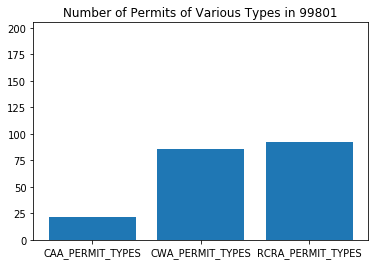

In [8]:
permit_cols = ["CAA_PERMIT_TYPES","CWA_PERMIT_TYPES","RCRA_PERMIT_TYPES"]

# Get a DataFrame with just the columns relating to permit type
permits = my_echo[permit_cols]
# Count how many non-null values are in each column
counted_permit_types = permits.count()

# Print how many values are present for each column (permitting law)
print(counted_permit_types)

# Graph the number of permits by which law they correspond to
plt.bar(counted_permit_types.keys(), counted_permit_types)
plt.ylim(top = num_facilities) # so the top of the graph is the total # of facilities in the region
plt.title("Number of Permits of Various Types in %s" %(my_zip))

CAA_PERMIT_TYPES
{'Synthetic Minor Emissions': 5, 'Minor Emissions': 13, 'Major Emissions': 4}


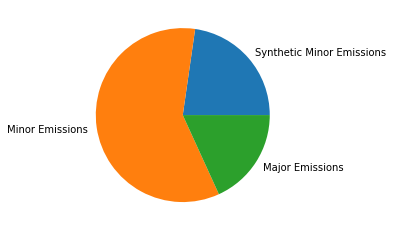

CWA_PERMIT_TYPES
{'Minor': 83, 'Major, Minor': 2, 'Major': 1}


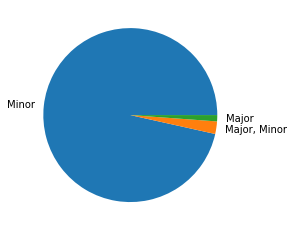

RCRA_PERMIT_TYPES
{'SQG, Transporter': 1, 'VSQG': 39, 'Transporter': 8, 'SQG': 5, 'Other': 32, 'LQG': 3, 'Transporter, VSQG': 3, 'Other, VSQG': 1}


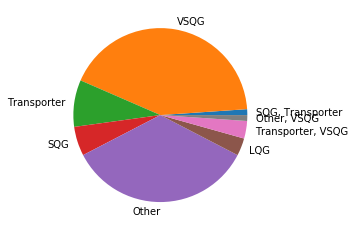

In [9]:
# Drilling down into what types of permits have been issued

# Define a function for counting permit types
def count_permits(permit_law):
    # Find all the possible permit types
    permit_types_with_nan = my_echo[permit_law].unique().tolist()
    # Remove null value as a permit type
    permit_types = [i for i in permit_types_with_nan if str(i) != "nan"] # note that nan values fail to be counted even when left in
    # Define a dictionary to save counted permits
    permits_issued = {}
    # For each permit type...
    for permit_type in permit_types:
        # Count those unique values and save them corresponding to their permit type
        permits_issued[permit_type] = my_echo[my_echo[permit_law] == permit_type].shape[0]
    # Return a tuple naming the law the permit is issued under and a dictionary counting its issued permits
    return (permits_issued)

# For each permit type
for permit_law in permit_cols:
    counted_permits = count_permits(permit_law)
    
    # Print the raw data
    print(permit_law)
    print(counted_permits)
    
    # Plot a pie chart breaking down type of permit in each category
    plt.pie(counted_permits.values(), labels = list(counted_permits.keys()))
    plt.show()


### This would be a good place to add context: what's a major vs. minor CAA permit? What is LQG or VSQG– or for that matter, what's RCRA?

Explanation goes here

## Are the facilities in my region in compliance with their permits?

A bit more detail: what is compliance vs. noncompliance? Does this mean they're currently exceeding their permits, that they usually do, that they have recently?

Text(0.5, 1.0, '27 of 205 Total Facilities Noncompliant in 99801 in the last 12 qtrs')

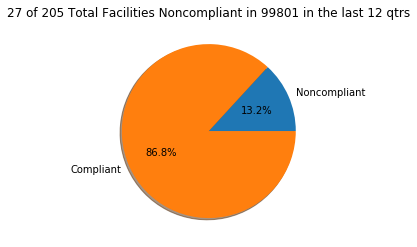

In [10]:
# How many facilities have been out of compliance in the last 12 quarters?

noncompliant = my_echo[my_echo["FAC_QTRS_WITH_NC"] > 0].sort_values(by="FAC_QTRS_WITH_NC", ascending=False)
num_noncompliant = noncompliant.shape[0]
plt.pie([num_noncompliant, num_facilities - num_noncompliant], labels=["Noncompliant", "Compliant"], autopct='%1.1f%%', shadow=True)

plt.title("%s of %s Total Facilities Noncompliant in %s in the last 12 qtrs" %(num_noncompliant, num_facilities, my_zip))

### Where are these noncompliant facilities?

In [11]:
map_of_noncompliant_facilities = mapper(noncompliant)
map_of_noncompliant_facilities

### Which facilities are out of compliance?

In [12]:
# Which facilities aren't in compliance?

print("Facilities in %s noncompliant in the last 12 quarters:" %my_zip)
cols_for_print = ["FAC_NAME", "FAC_QTRS_WITH_NC", "FAC_3YR_COMPLIANCE_HISTORY", "FAC_INSPECTION_COUNT"]
cols_for_print.extend(permit_cols)
print(noncompliant[cols_for_print])

Facilities in 99801 noncompliant in the last 12 quarters:
                                              FAC_NAME  FAC_QTRS_WITH_NC  \
1481286                        ALASKA GLACIER SEAFOODS              12.0   
231079                                  CHURCHILL PARK              11.0   
378265                         EXCURSION INLET CANNERY              11.0   
1907631                   THUNDER MOUNTAIN MOBILE PARK              11.0   
1606035      JUNEAU DOUGLAS WASTEWATER TREATMENT PLANT              11.0   
2241511                                 JUNEAU AJ MINE              10.0   
822259                            SHRINE OF ST THERESE              10.0   
133462           ALASKA MARINE HIGHWAY JUNEAU TERMINAL              10.0   
935166                        TAKU FISHERIES/SMOKERIES              10.0   
1378298                         MENDENHALL VALLEY WWTP               9.0   
21261         SEAWALK-BRIDGE TO GOLD CREEK , PHASE III               9.0   
500020                    KENS

# Next questions
* What are the top 3 noncompliant facilities in the zip code and what are they violating?
* Which types of noncompliance are we experiencing here?
* Beyond "significant" – how much over their permits are they?
